In [1]:
import pandas as pd
loans2019q1 = pd.read_csv('LoanStats_2019Q1.csv', 
                          skiprows=1, skipfooter=2, engine='python').drop(['id'],axis=1)
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
browse = pd.read_csv('primaryMarketNotes_browseNotes_1-RETAIL.csv')
browse.shape, loans2019q1.shape

((58, 122), (115675, 143))

In [2]:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [3]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [4]:
#SAME as the lecture

history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [45]:
#I removed the Ys so thta i can Under-sample the majority class in the Train data

# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
# target = 'loan_status'
# X = history.drop(columns=target)
# y = history[target]
target = 'loan_status'
size = round(0.2*len(history))

# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test = train_test_split(
    history, test_size=20000, stratify=history[target], random_state=42)

X_train, X_val = train_test_split(
    X_trainval, test_size=20000, 
    stratify=X_trainval[target], random_state=42)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)


X_train shape (88334, 153)
X_val shape (20000, 153)
X_test shape (20000, 153)


In [46]:
# Under-sampling the majority.

X_train_0 = X_train.loc[X_train['loan_status'] == 'Charged Off']
X_train_1 = X_train.loc[X_train['loan_status'] == 'Fully Paid'].sample(n=round(3*len(X_train_0)))
X_train = pd.concat([X_train_1,X_train_0])


In [47]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [48]:
len(X_train_1), len(X_train_0)

(46413, 15471)

In [49]:
X_test.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_d_year,issue_d_month,percent_paid
25739,8626171.0,NaN,28000.0,28000.0,28000.0,36 months,13.67%,952.50,B,B5,CFO,1 year,RENT,275000.0,Verified,2013-11-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,070xx,NJ,10.47,0.0,5997,710.0,714.0,1.0,NaN,NaN,12.0,0.0,37040.0,79.8%,29.0,w,0.0,0.0,34239.560000,34239.56,28000.0,6239.56,0.0,0.0,0.0,Sep-2016,3759.56,NaN,May-2019,664.0,660.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,487635.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46400.0,NaN,NaN,NaN,3.0,40636.0,7588.0,82.9,0.0,0.0,181.0,197.0,3.0,3.0,2.0,3.0,NaN,4.0,NaN,0.0,6.0,7.0,7.0,16.0,10.0,8.0,17.0,7.0,12.0,0.0,0.0,0.0,2.0,100.0,71.4,0.0,0.0,548056.0,158328.0,44400.0,154778.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2013,11,1.222841
125307,94031368.0,NaN,7000.0,7000.0,7000.0,36 months,11.49%,230.80,B,B5,Network Coordinator,4 years,RENT,59000.0,Verified,2016-11-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,320xx,FL,20.00,0.0,1400,680.0,684.0,1.0,NaN,NaN,8.0,0.0,5179.0,71.9%,9.0,w,0.0,0.0,8072.507795,8072.51,7000.0,1072.51,0.0,0.0,0.0,Sep-2018,3256.99,NaN,Mar-2019,749.0,745.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,60.0,37210.0,3.0,3.0,1.0,2.0,6.0,32031.0,72.0,2.0,3.0,2367.0,72.0,7200.0,1.0,6.0,3.0,5.0,4651.0,633.0,78.9,0.0,0.0,46.0,32.0,1.0,1.0,0.0,19.0,NaN,1.0,NaN,0.0,1.0,5.0,1.0,1.0,4.0,5.0,5.0,5.0,8.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,51809.0,37210.0,3000.0,446

In [50]:
# Set targets
y_test = X_test[target]
y_train = X_train[target]
y_val = X_val[target]
X_train = X_train.drop(columns=target)
X_test = X_test.drop(columns=target)
X_val = X_val.drop(columns=target)

In [51]:

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (61884, 152)
y_train shape (61884,)
X_val shape (20000, 152)
y_val shape (20000,)
X_test shape (20000, 152)
y_test shape (20000,)


In [52]:
# Save the actual results, to compare later with predicted results
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()

result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate
47563,11336218.0,2014-01-01,D,1.439103,60 months,16.99%
83314,127629418.0,2018-01-01,D,1.172302,36 months,20.00%
740,555478.0,2010-08-01,D,1.217144,36 months,15.95%
60350,106493943.0,2017-04-01,C,1.158069,60 months,12.74%
121119,68368766.0,2016-01-01,A,1.048598,36 months,5.32%


In [53]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [54]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train_wrangled = wrangle(X_train)
X_val_wrangled   = wrangle(X_val)
X_test_wrangled  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)


X_train shape (61884, 108)
X_val shape (20000, 108)
X_test shape (20000, 108)


In [55]:
# Applying the model on the UNDER-SAMPLING Method

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train_wrangled)
X_val_processed = processor.transform(X_val_wrangled)
# smt = SMOTE(sampling_strategy='minority')
# X_train_processed, y_train = smt.fit_sample(X_train_processed, y_train)
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.671272	validation_1-auc:0.673752
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.672816	validation_1-auc:0.67649
[2]	validation_0-auc:0.676916	validation_1-auc:0.680165
[3]	validation_0-auc:0.681877	validation_1-auc:0.685389
[4]	validation_0-auc:0.684464	validation_1-auc:0.68701
[5]	validation_0-auc:0.685925	validation_1-auc:0.687927
[6]	validation_0-auc:0.687215	validation_1-auc:0.688166
[7]	validation_0-auc:0.687405	validation_1-auc:0.687823
[8]	validation_0-auc:0.688205	validation_1-auc:0.689313
[9]	validation_0-auc:0.688789	validation_1-auc:0.689925
[10]	validation_0-auc:0.689619	validation_1-auc:0.690557
[11]	validation_0-auc:0.690244	validation_1-auc:0.691298
[12]	validation_0-auc:0.690771	validation_1-auc:0.691859
[13]	validation_0-auc:0.691091	validation_1-auc:0.691938
[14]	validation_0-auc:0.691337	validation_1-auc:0.692299


[141]	validation_0-auc:0.733223	validation_1-auc:0.717891
[142]	validation_0-auc:0.733379	validation_1-auc:0.71791
[143]	validation_0-auc:0.733563	validation_1-auc:0.718106
[144]	validation_0-auc:0.733612	validation_1-auc:0.718165
[145]	validation_0-auc:0.733722	validation_1-auc:0.718169
[146]	validation_0-auc:0.733803	validation_1-auc:0.718194
[147]	validation_0-auc:0.733914	validation_1-auc:0.718193
[148]	validation_0-auc:0.734104	validation_1-auc:0.718184
[149]	validation_0-auc:0.734204	validation_1-auc:0.718236
[150]	validation_0-auc:0.734358	validation_1-auc:0.718156
[151]	validation_0-auc:0.734436	validation_1-auc:0.718159
[152]	validation_0-auc:0.73454	validation_1-auc:0.718187
[153]	validation_0-auc:0.734666	validation_1-auc:0.71821
[154]	validation_0-auc:0.734726	validation_1-auc:0.718261
[155]	validation_0-auc:0.73485	validation_1-auc:0.718295
[156]	validation_0-auc:0.735074	validation_1-auc:0.718525
[157]	validation_0-auc:0.735212	validation_1-auc:0.718562
[158]	validation_0

[283]	validation_0-auc:0.749733	validation_1-auc:0.721996
[284]	validation_0-auc:0.749843	validation_1-auc:0.722014
[285]	validation_0-auc:0.749963	validation_1-auc:0.722045
[286]	validation_0-auc:0.750062	validation_1-auc:0.722008
[287]	validation_0-auc:0.750163	validation_1-auc:0.722005
[288]	validation_0-auc:0.750215	validation_1-auc:0.722009
[289]	validation_0-auc:0.750258	validation_1-auc:0.722024
[290]	validation_0-auc:0.750305	validation_1-auc:0.722034
[291]	validation_0-auc:0.75034	validation_1-auc:0.722009
[292]	validation_0-auc:0.750427	validation_1-auc:0.72195
[293]	validation_0-auc:0.75059	validation_1-auc:0.721976
[294]	validation_0-auc:0.750674	validation_1-auc:0.72198
[295]	validation_0-auc:0.750825	validation_1-auc:0.721949
Stopping. Best iteration:
[285]	validation_0-auc:0.749963	validation_1-auc:0.722045



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [56]:
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
y_pred = model.predict(X_val_processed)
accuracy_score(y_val, y_pred)

0.82105

In [57]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

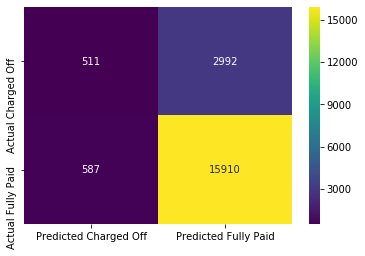

In [58]:
import seaborn as sns
plot_confusion_matrix(y_val, y_pred);

In [59]:
from sklearn.metrics import roc_auc_score, roc_curve

print(classification_report(y_val, y_pred))
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
roc_auc_score(y_val, y_pred_proba)

              precision    recall  f1-score   support

 Charged Off       0.47      0.15      0.22      3503
  Fully Paid       0.84      0.96      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.65      0.56      0.56     20000
weighted avg       0.78      0.82      0.78     20000



0.7220450864075478

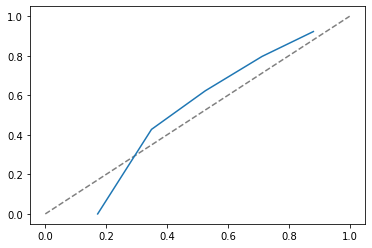

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=5)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

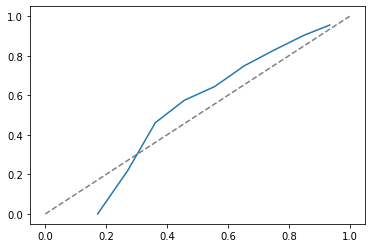

In [61]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

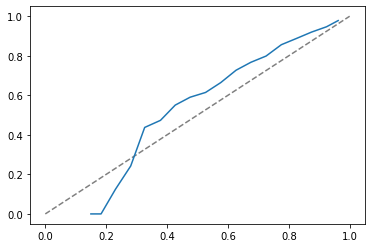

In [62]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=20)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

In [63]:
def get_results(result_df, y_true, y_pred_proba):
    result_df = result_df.copy()
    result_df['loan_status'] = y_true
    result_df['pred_proba'] = y_pred_proba
    result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)
    result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
    result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
    result_df['best_case'] = 25 + result_df['max_interest']/100 * 25
    result_df['worst_case'] = -25
    result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case'] 
                                   + (1-result_df['pred_proba']) * result_df['worst_case'])
    return result_df

result_val1 = get_results(result_val1, y_val, y_pred_proba)

In [64]:
result_val1.head()

,id,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,max_interest,best_case,worst_case,expected_value
47563,11336218.0,2014-01-01,D,1.439103,60,16.99,Fully Paid,0.641244,84.95,46.2375,-25,20.680653
83314,127629418.0,2018-01-01,D,1.172302,36,20.00,Fully Paid,0.719992,60.00,40.0000,-25,21.799452
740,555478.0,2010-08-01,D,1.217144,36,15.95,Fully Paid,0.688015,47.85,36.9625,-25,17.631125
60350,106493943.0,2017-04-01,C,1.158069,60,12.74,Fully Paid,0.529594,63.70,40.9250,-25,9.913481
121119,68368766.0,2016-01-01,A,1.048598,36,5.32,Fully Paid,0.968962,15.96,28.9900,-25,27.314233


In [65]:
%matplotlib inline
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(df, n_picks=40, n_sims=10000, 
             grades=['A','B','C','D'], 
             start_date='2007-07-01', 
             end_date='2019-03-01', 
             min_expected_value=-25):
    """
    What if you picked random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((df['grade'].isin(grades)) & 
                 (df['issue_d'] >= start_date) &
                 (df['issue_d'] <= end_date) & 
                 (df['expected_value'] >= min_expected_value))
    possible = df[condition]
    
    simulations = []
    for _ in tnrange(n_sims):
        picks = possible.sample(n_picks).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    print(f'#### {n_picks} loans picked from {len(possible)} possible loans')
    print(f'- Dates: {start_date}-{end_date}\n' + 
                     f'- Grades: {grades}\n' +
                     f'- Expected Value >= {min_expected_value}')
    print(f'#### Range of results from {n_sims} simulations')
    print(simulations.describe().to_string())
    plt.title(f'{percent}% of simulations did not profit.')


#### 40 loans picked from 20000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= -25
#### Range of results from 10000 simulations
count    10000.000000
mean      1041.753050
std         42.519185
min        874.058625
25%       1014.054499
50%       1044.084969
75%       1071.659236
max       1171.226943


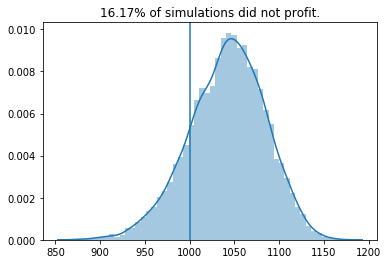

In [66]:
simulate(result_val1)


#### 40 loans picked from 3986 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A']
- Expected Value >= -25
#### Range of results from 10000 simulations
count    10000.000000
mean      1052.092369
std         23.084048
min        925.259349
25%       1038.033874
50%       1054.708987
75%       1069.076861
max       1102.971573


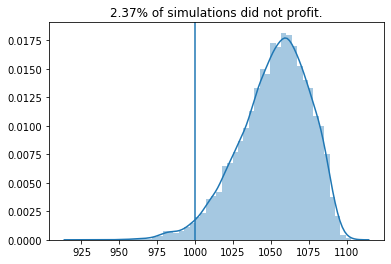

In [67]:
simulate(result_val1, grades=['A'])


#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 26.054253065526485
#### Range of results from 10000 simulations
count    10000.000000
mean      1086.620082
std         27.621122
min        951.689657
25%       1069.505703
50%       1088.456740
75%       1106.219654
max       1176.941645


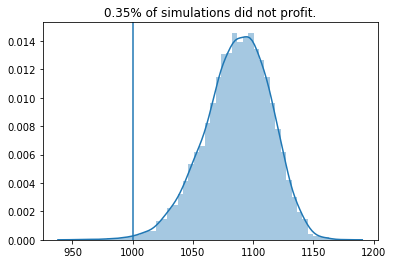

In [68]:
import numpy as np
min_expected_value = np.percentile(result_val['expected_value'], 80)
simulate(result_val1, min_expected_value=min_expected_value)

In [69]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test_wrangled)
print(classification_report(y_val, y_pred))

y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

 Charged Off       0.47      0.15      0.22      3503
  Fully Paid       0.84      0.96      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.65      0.56      0.56     20000
weighted avg       0.78      0.82      0.78     20000

Test ROC AUC: 0.7106176589932156


In [70]:
from sklearn.metrics import roc_auc_score, roc_curve

print(classification_report(y_val, y_pred))
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
roc_auc_score(y_val, y_pred_proba)

              precision    recall  f1-score   support

 Charged Off       0.47      0.15      0.22      3503
  Fully Paid       0.84      0.96      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.65      0.56      0.56     20000
weighted avg       0.78      0.82      0.78     20000



0.7220450864075478

In [71]:
result_test1 = get_results(result_test, y_test, y_pred_proba)


In [72]:

df = result_test1.copy()
condition = (df['expected_value'] >= min_expected_value)
possible = df[condition]
picks = possible.sample(40, random_state=42).copy()


In [73]:
picks.head()

,id,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,max_interest,best_case,worst_case,expected_value
92837,16602385.0,2014-05-01,C,1.242031,60,14.99,Fully Paid,0.787411,74.95,43.7375,-25,29.124645
74694,59292208.0,2015-09-01,C,1.222320,60,13.33,Fully Paid,0.802945,66.65,41.6625,-25,28.526330
70948,12315057.0,2014-02-01,C,1.333252,60,15.31,Fully Paid,0.777980,76.55,44.1375,-25,28.787590
22609,1034896.0,2011-12-01,D,0.250665,60,18.25,Charged Off,0.905789,91.25,47.8125,-25,40.952797
63429,120602025.0,2017-10-01,C,1.062998,36,14.08,Fully Paid,0.853203,42.24,35.5600,-25,26.669999


In [74]:
data_for_prediction = X_test[X_test.index==2059]
data_for_prediction

,mths_since_recent_revol_delinq,acc_now_delinq,member_id,total_rev_hi_lim,pub_rec,mo_sin_rcnt_rev_tl_op,purpose,desc,sec_app_fico_range_low,total_il_high_credit_limit,num_rev_accts,mort_acc,il_util,num_accts_ever_120_pd,open_rv_24m,open_il_12m,total_acc,avg_cur_bal,annual_inc,num_tl_30dpd,term,url,num_rev_tl_bal_gt_0,sec_app_collections_12_mths_ex_med,inq_fi,inq_last_12m,initial_list_status,num_op_rev_tl,mths_since_recent_bc,loan_amnt,sub_grade,sec_app_fico_range_high,total_bal_ex_mort,mths_since_last_record,sec_app_open_acc,fico_range_high,total_bal_il,installment,tax_liens,acc_open_past_24mths,mths_since_last_delinq,pct_tl_nvr_dlq,all_util,collections_12_mths_ex_med,num_il_tl,zip_code,mths_since_rcnt_il,sec_app_inq_last_6mths,title,num_bc_tl,num_tl_120dpd_2m,emp_title,sec_app_earliest_cr_line,issue_d_year,bc_util,mo_sin_rcnt_tl,open_acc_6m,max_bal_bc,int_rate,total_bc_limit,revol_bal_joint,open_il_24m,issue_d_month,dti_joint,num_actv_rev_tl,sec_app_num_rev_accts,mo_sin_old_il_acct,funded_amnt,inq_last_6mths,tot_coll_amt,bc_open_to_buy,earliest_cr_line,pub_rec_bankruptcies,open_acc,total_cu_tl,num_actv_bc_tl,home_ownership,mths_since_last_major_derog,dti,delinq_amnt,delinq_2yrs,revol_util,mths_since_recent_inq,revol_bal,mths_since_recent_bc_dlq,grade,tot_cur_bal,num_bc_sats,sec_app_chargeoff_within_12_mths,chargeoff_within_12_mths,open_act_il,id,percent_bc_gt_75,num_sats,num_tl_op_past_12m,sec_app_mths_since_last_major_derog,sec_app_mort_acc,open_rv_12m,tot_hi_cred_lim,mo_sin_old_rev_tl_op,application_type,num_tl_90g_dpd_24m,annual_inc_joint,sec_app_open_act_il,addr_state,fico_range_low,emp_length,sec_app_revol_util
2059,22.0,0.0,NaN,14000.0,0.0,26.0,debt_consolidation,Borrower added on 01/23/14 > FOR DEB CONSOLI...,NaN,14680.0,22.0,0.0,NaN,1.0,NaN,NaN,31.0,1961.0,65000.0,0.0,36 months,https://lendingclub.com/browse/loanDetail.acti...,7.0,NaN,NaN,NaN,f,10.0,28.0,5000.0,B4,NaN,21575.0,NaN,NaN,684.0,NaN,168.11,0.0,1.0,22.0,93.5,NaN,0.0,8.0,115xx,NaN,NaN,Debt consolidation,16.0,0.0,NaN,NaN,2014,69.6,3.0,NaN,NaN,12.85%,10200.0,NaN,NaN,1,NaN,7.0,NaN,156.0,5000.0,2.0,22366.0,3097.0,5420,0.0,11.0,NaN,5.0,RENT,61.0,12.83,0.0,1.0,58%,1.0,8118.0,NaN,B,21575.0,6.0,NaN,0.0,NaN,10875088.0,50.0,11.0,1.0,NaN,NaN,NaN,28680.0,178.0,Individual,0.0,NaN,NaN,NY,680.0,2 years,NaN


In [75]:
data_for_prediction_processed = processor.transform(wrangle(data_for_prediction))
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = wrangle(data_for_prediction).columns

In [76]:
# ERROR

# import shap
# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(data_for_prediction_processed)
# shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

In [77]:
y_train == 'Fully Paid'

86377      True
14826      True
119661     True
16893      True
12639      True
92768      True
28380      True
68770      True
48276      True
124129     True
3246       True
55214      True
72000      True
3997       True
26316      True
16292      True
119863     True
89464      True
18936      True
117368     True
59394      True
38050      True
80705      True
53680      True
94001      True
20130      True
61002      True
56363      True
88738      True
76535      True
31549      True
27667      True
84284      True
97939      True
105411     True
5085       True
124476     True
50729      True
61928      True
33431      True
97232      True
112405     True
106190     True
96648      True
30886      True
66749      True
68365      True
118823     True
117244     True
105515     True
26832      True
93856      True
37674      True
119900     True
111812     True
113290     True
48058      True
78473      True
50890      True
109533     True
114573     True
89450      True
50584   

In [81]:
# NEAR MISS

history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
# target = 'loan_status'
# X = history.drop(columns=target)
# y = history[target]
target = 'loan_status'
size = round(0.2*len(history))

# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test = train_test_split(
    history, test_size=20000, stratify=history[target], random_state=42)

X_train, X_val = train_test_split(
    X_trainval, test_size=20000, 
    stratify=X_trainval[target], random_state=42)


y_test = X_test[target]
y_train = X_train[target]
y_val = X_val[target]
X_train = X_train.drop(columns=target)
X_test = X_test.drop(columns=target)
X_val = X_val.drop(columns=target)


# Save the actual results, to compare later with predicted results
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()

result_val.head()

# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train_wrangled = wrangle(X_train)
X_val_wrangled   = wrangle(X_val)
X_test_wrangled  = wrangle(X_test)


import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train_wrangled)
X_val_processed = processor.transform(X_val_wrangled)

nr = NearMiss()
X_train_processed, y_train = nr.fit_sample(X_train_processed, y_train)
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.791997	validation_1-auc:0.459643
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.815493	validation_1-auc:0.463102
[2]	validation_0-auc:0.830375	validation_1-auc:0.466406
[3]	validation_0-auc:0.832704	validation_1-auc:0.466093
[4]	validation_0-auc:0.838724	validation_1-auc:0.463783
[5]	validation_0-auc:0.838372	validation_1-auc:0.46746
[6]	validation_0-auc:0.853984	validation_1-auc:0.471039
[7]	validation_0-auc:0.856268	validation_1-auc:0.471511
[8]	validation_0-auc:0.859979	validation_1-auc:0.471321
[9]	validation_0-auc:0.86062	validation_1-auc:0.471901
[10]	validation_0-auc:0.863347	validation_1-auc:0.473487
[11]	validation_0-auc:0.864465	validation_1-auc:0.474972
[12]	validation_0-auc:0.866439	validation_1-auc:0.476439
[13]	validation_0-auc:0.866805	validation_1-auc:0.476885
[14]	validation_0-auc:0.867409	validation_1-auc:0.476484


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [83]:
def get_results(result_df, y_true, y_pred_proba):
    result_df = result_df.copy()
    result_df['loan_status'] = y_true
    result_df['pred_proba'] = y_pred_proba
    result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)
    result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
    result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
    result_df['best_case'] = 25 + result_df['max_interest']/100 * 25
    result_df['worst_case'] = -25
    result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case'] 
                                   + (1-result_df['pred_proba']) * result_df['worst_case'])
    return result_df

result_val = get_results(result_val, y_val, y_pred_proba)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas


#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 26.054253065526485
#### Range of results from 10000 simulations
count    10000.000000
mean      1086.922760
std         27.646098
min        958.289773
25%       1069.449645
50%       1089.190207
75%       1106.653949
max       1175.538312


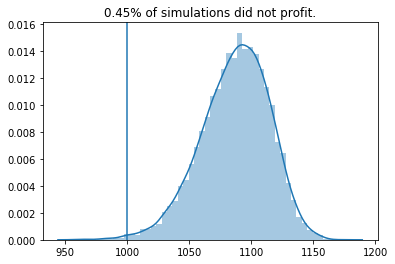

In [84]:
import numpy as np
min_expected_value = np.percentile(result_val['expected_value'], 80)
simulate(result_val, min_expected_value=min_expected_value)

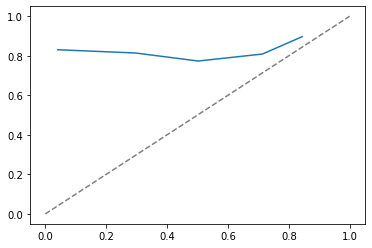

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=5)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

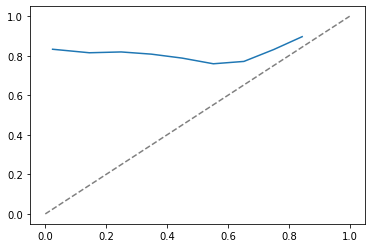

In [86]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

In [87]:
# SMOTE

history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
# target = 'loan_status'
# X = history.drop(columns=target)
# y = history[target]
target = 'loan_status'
size = round(0.2*len(history))

# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test = train_test_split(
    history, test_size=20000, stratify=history[target], random_state=42)

X_train, X_val = train_test_split(
    X_trainval, test_size=20000, 
    stratify=X_trainval[target], random_state=42)


y_test = X_test[target]
y_train = X_train[target]
y_val = X_val[target]
X_train = X_train.drop(columns=target)
X_test = X_test.drop(columns=target)
X_val = X_val.drop(columns=target)


# Save the actual results, to compare later with predicted results
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()

result_val.head()

# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train_wrangled = wrangle(X_train)
X_val_wrangled   = wrangle(X_val)
X_test_wrangled  = wrangle(X_test)

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train_wrangled)
X_val_processed = processor.transform(X_val_wrangled)
smt = SMOTE(sampling_strategy='minority')
X_train_processed, y_train = smt.fit_sample(X_train_processed, y_train)
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.770592	validation_1-auc:0.617784
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.792724	validation_1-auc:0.63263
[2]	validation_0-auc:0.822356	validation_1-auc:0.645617
[3]	validation_0-auc:0.820853	validation_1-auc:0.650795
[4]	validation_0-auc:0.823809	validation_1-auc:0.645775
[5]	validation_0-auc:0.828856	validation_1-auc:0.646776
[6]	validation_0-auc:0.844764	validation_1-auc:0.655577
[7]	validation_0-auc:0.855554	validation_1-auc:0.660048
[8]	validation_0-auc:0.867435	validation_1-auc:0.66097
[9]	validation_0-auc:0.87225	validation_1-auc:0.663678
[10]	validation_0-auc:0.874714	validation_1-auc:0.666181
[11]	validation_0-auc:0.880687	validation_1-auc:0.669413
[12]	validation_0-auc:0.886931	validation_1-auc:0.669473
[13]	validation_0-auc:0.892128	validation_1-auc:0.670142
[14]	validation_0-auc:0.893525	validation_1-auc:0.667966
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [88]:
def get_results(result_df, y_true, y_pred_proba):
    result_df = result_df.copy()
    result_df['loan_status'] = y_true
    result_df['pred_proba'] = y_pred_proba
    result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)
    result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
    result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
    result_df['best_case'] = 25 + result_df['max_interest']/100 * 25
    result_df['worst_case'] = -25
    result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case'] 
                                   + (1-result_df['pred_proba']) * result_df['worst_case'])
    return result_df

result_val = get_results(result_val, y_val, y_pred_proba)


#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 15.34159240809083
#### Range of results from 10000 simulations
count    10000.000000
mean      1074.711704
std         38.155403
min        891.076882
25%       1049.432525
50%       1077.025764
75%       1101.056783
max       1198.310207


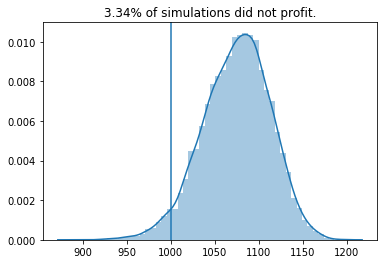

In [89]:
import numpy as np
min_expected_value = np.percentile(result_val['expected_value'], 80)
simulate(result_val, min_expected_value=min_expected_value)

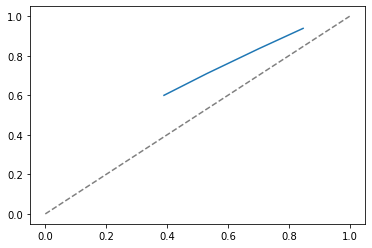

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=5)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

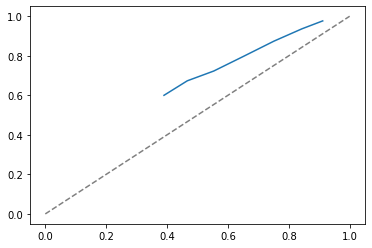

In [91]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

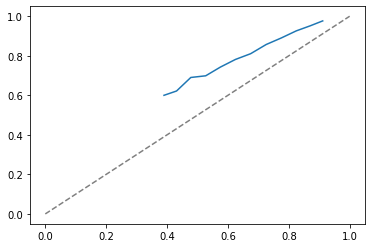

In [92]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=20)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

In [93]:
# SMOTE AND UNDER-SAMPLING
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
# target = 'loan_status'
# X = history.drop(columns=target)
# y = history[target]
target = 'loan_status'
size = round(0.2*len(history))

# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test = train_test_split(
    history, test_size=20000, stratify=history[target], random_state=42)

X_train, X_val = train_test_split(
    X_trainval, test_size=20000, 
    stratify=X_trainval[target], random_state=42)


X_train_0 = X_train.loc[X_train['loan_status'] == 'Charged Off']
X_train_1 = X_train.loc[X_train['loan_status'] == 'Fully Paid'].sample(n=round(3*len(X_train_0)))
X_train = pd.concat([X_train_1,X_train_0])

y_test = X_test[target]
y_train = X_train[target]
y_val = X_val[target]
X_train = X_train.drop(columns=target)
X_test = X_test.drop(columns=target)
X_val = X_val.drop(columns=target)



# Save the actual results, to compare later with predicted results
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()

result_val.head()

# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train_wrangled = wrangle(X_train)
X_val_wrangled   = wrangle(X_val)
X_test_wrangled  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)


X_train shape (61884, 108)
X_val shape (20000, 108)
X_test shape (20000, 108)


In [94]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train_wrangled)
X_val_processed = processor.transform(X_val_wrangled)
smt = SMOTE(sampling_strategy='not minority')
X_train_processed, y_train = smt.fit_sample(X_train_processed, y_train)
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.670625	validation_1-auc:0.675992
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.67183	validation_1-auc:0.674089
[2]	validation_0-auc:0.677463	validation_1-auc:0.680611
[3]	validation_0-auc:0.680824	validation_1-auc:0.683785
[4]	validation_0-auc:0.683206	validation_1-auc:0.685719
[5]	validation_0-auc:0.683821	validation_1-auc:0.686491
[6]	validation_0-auc:0.68513	validation_1-auc:0.687239
[7]	validation_0-auc:0.685677	validation_1-auc:0.687476
[8]	validation_0-auc:0.68625	validation_1-auc:0.688198
[9]	validation_0-auc:0.686993	validation_1-auc:0.689263
[10]	validation_0-auc:0.687953	validation_1-auc:0.69012
[11]	validation_0-auc:0.688773	validation_1-auc:0.690716
[12]	validation_0-auc:0.689178	validation_1-auc:0.691344
[13]	validation_0-auc:0.689244	validation_1-auc:0.691475
[14]	validation_0-auc:0.689727	validation_1-auc:0.69226
[15

[141]	validation_0-auc:0.732063	validation_1-auc:0.718146
[142]	validation_0-auc:0.7322	validation_1-auc:0.718145
[143]	validation_0-auc:0.732251	validation_1-auc:0.718197
[144]	validation_0-auc:0.732312	validation_1-auc:0.718236
[145]	validation_0-auc:0.732386	validation_1-auc:0.718228
[146]	validation_0-auc:0.732607	validation_1-auc:0.718185
[147]	validation_0-auc:0.73275	validation_1-auc:0.718217
[148]	validation_0-auc:0.73297	validation_1-auc:0.718296
[149]	validation_0-auc:0.733167	validation_1-auc:0.718294
[150]	validation_0-auc:0.73328	validation_1-auc:0.718263
[151]	validation_0-auc:0.733351	validation_1-auc:0.718307
[152]	validation_0-auc:0.733474	validation_1-auc:0.718341
[153]	validation_0-auc:0.733667	validation_1-auc:0.71833
[154]	validation_0-auc:0.733801	validation_1-auc:0.718329
[155]	validation_0-auc:0.733912	validation_1-auc:0.718359
[156]	validation_0-auc:0.734108	validation_1-auc:0.718482
[157]	validation_0-auc:0.73423	validation_1-auc:0.718519
[158]	validation_0-au

[283]	validation_0-auc:0.749041	validation_1-auc:0.721656
[284]	validation_0-auc:0.749208	validation_1-auc:0.721712
[285]	validation_0-auc:0.749289	validation_1-auc:0.721662
[286]	validation_0-auc:0.749426	validation_1-auc:0.721623
[287]	validation_0-auc:0.749498	validation_1-auc:0.721648
[288]	validation_0-auc:0.749652	validation_1-auc:0.721728
[289]	validation_0-auc:0.74978	validation_1-auc:0.721818
[290]	validation_0-auc:0.749931	validation_1-auc:0.72182
[291]	validation_0-auc:0.750031	validation_1-auc:0.721874
[292]	validation_0-auc:0.750186	validation_1-auc:0.721869
[293]	validation_0-auc:0.750216	validation_1-auc:0.721869
[294]	validation_0-auc:0.75025	validation_1-auc:0.721879
[295]	validation_0-auc:0.750379	validation_1-auc:0.721831
[296]	validation_0-auc:0.750465	validation_1-auc:0.721849
[297]	validation_0-auc:0.750536	validation_1-auc:0.721831
[298]	validation_0-auc:0.750575	validation_1-auc:0.721861
[299]	validation_0-auc:0.75073	validation_1-auc:0.721898
[300]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [95]:
def get_results(result_df, y_true, y_pred_proba):
    result_df = result_df.copy()
    result_df['loan_status'] = y_true
    result_df['pred_proba'] = y_pred_proba
    result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)
    result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
    result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
    result_df['best_case'] = 25 + result_df['max_interest']/100 * 25
    result_df['worst_case'] = -25
    result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case'] 
                                   + (1-result_df['pred_proba']) * result_df['worst_case'])
    return result_df

result_val2 = get_results(result_val, y_val, y_pred_proba)


#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 21.429362146466968
#### Range of results from 10000 simulations
count    10000.000000
mean      1074.201990
std         28.826365
min        947.039725
25%       1056.220099
50%       1076.223698
75%       1095.332176
max       1155.236407


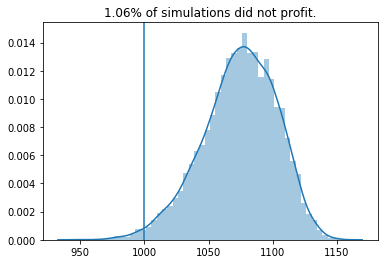

In [97]:
import numpy as np
min_expected_value = np.percentile(result_val2['expected_value'], 80)
simulate(result_val2, min_expected_value=min_expected_value)

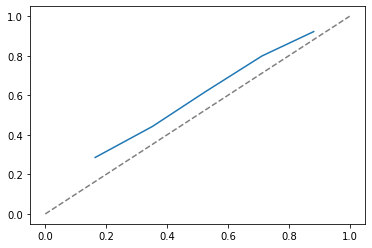

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=5)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

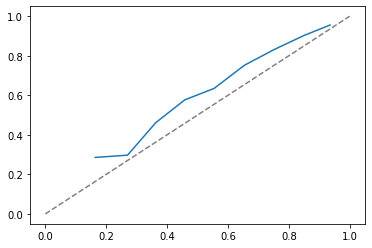

In [99]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

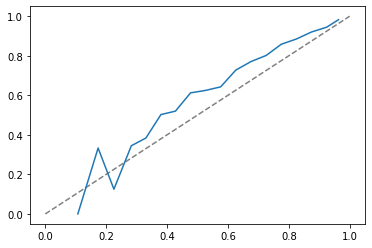

In [100]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=20)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

In [101]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test_wrangled)
print(classification_report(y_val, y_pred))

y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

from sklearn.metrics import roc_auc_score, roc_curve

print(classification_report(y_val, y_pred))
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
roc_auc_score(y_val, y_pred_proba)

              precision    recall  f1-score   support

 Charged Off       0.47      0.15      0.22      3503
  Fully Paid       0.84      0.96      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.65      0.56      0.56     20000
weighted avg       0.78      0.82      0.78     20000

Test ROC AUC: 0.70921500429035
              precision    recall  f1-score   support

 Charged Off       0.47      0.15      0.22      3503
  Fully Paid       0.84      0.96      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.65      0.56      0.56     20000
weighted avg       0.78      0.82      0.78     20000



0.7225686030752813